# Training an MLP on Time Series Data
This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) network using the 3W dataset for Multiclass Classification with Time Series data using the ThreeWToolkit.

### Imports
We start by importing the required libraries and classes from the Toolkit. 

In [1]:
from ThreeWToolkit.trainer.trainer import ModelTrainer, TrainerConfig
from ThreeWToolkit.models.mlp import MLPConfig
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig
from ThreeWToolkit.core.base_preprocessing import WindowingConfig
from ThreeWToolkit.core.base_assessment import ModelAssessmentConfig
from ThreeWToolkit.preprocessing import Windowing
from ThreeWToolkit.assessment.assessment_visualizations import AssessmentVisualization
from ThreeWToolkit.core.base_assessment_visualization import (
    AssessmentVisualizationConfig,
)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

RANDOM_SEED = 2025

/home/eduardo/doc/3W/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading dataset

The next step is to create a ParqueDataset instance to interact with the *3W dataset*, for that we have to define a path location where we want to save the Dataset to (or where it is already located).

In [2]:
ds_config = ParquetDatasetConfig(
    path="../../dataset", clean_data=True, seed=RANDOM_SEED, target_class=[0, 1, 2]
)
ds = ParquetDataset(ds_config)
ds[19]

[ParquetDataset] Dataset found at ../../dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


{'signal':                      ABER-CKGL  ABER-CKP  ESTADO-DHSV  ESTADO-M1  ESTADO-M2  \
 timestamp                                                                     
 2018-05-13 04:49:38        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:39        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:40        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:41        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 04:49:42        0.0       0.0          0.0        0.0        0.0   
 ...                        ...       ...          ...        ...        ...   
 2018-05-13 12:49:32        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:33        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:34        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:35        0.0       0.0          0.0        0.0        0.0   
 2018-05-13 12:49:36        0.

### Model Trainer Configurations

With the data ready, we are now able to define the **ModelTrainer**, using using the MLPConfig and *TrainerConfig* configuration classes.

- Very important to note that the *TrainerConfig* class receives as a parameter the model configuration (config_model), and we use this information to instantiate **ModelTrainer**.   

In [3]:
window_size = 1000
mlp_config = MLPConfig(
    input_size=window_size,
    hidden_sizes=(32, 16),
    output_size=3,
    random_seed=RANDOM_SEED,
    activation_function="relu",
    regularization=None,
)

trainer_config = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=RANDOM_SEED,
    config_model=mlp_config,
    learning_rate=0.001,
    cross_validation=False,
    shuffle_train=True,
)

trainer = ModelTrainer(trainer_config)

### Prepare data for training without Pipeline Class

When using Time Series data, is very important to mantain consistence regarding data input to the model, for solving this we use the *Sliding Window* method. 

When using the **ModelTrainer** without the Pipeline class, we have to use the *windowing* function in order to prepare the dataset for training. 

- Also while using the isolated classes, we need to prepare the DataFrame event by event, creating a combined DataFrame with all windows and labels. 

In [4]:
windowing_config = WindowingConfig(
    window="hann", window_size=window_size, overlap=0.5, pad_last_window=True
)
windowing = Windowing(windowing_config)
selected_col = "T-TPT"
dfs = []

for event in ds:
    windowed_signal = windowing(
        event["signal"][selected_col],
    )
    windowed_signal.drop(columns=["win"], inplace=True)
    windowed_signal["label"] = np.unique(event["label"]["class"])[0]
    dfs.append(windowed_signal)

dfs_final = pd.concat(dfs, ignore_index=True, axis=0)
dfs_final

,var1_t0,var1_t1,var1_t2,var1_t3,var1_t4,var1_t5,var1_t6,var1_t7,var1_t8,var1_t9,...,var1_t991,var1_t992,var1_t993,var1_t994,var1_t995,var1_t996,var1_t997,var1_t998,var1_t999,label
0,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
1,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
2,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
3,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
4,0.0,0.000009,0.000037,0.000084,0.000149,0.000233,0.000335,0.000456,0.000596,0.000754,...,0.000754,0.000596,0.000456,0.000335,0.000233,0.000149,0.000084,0.000037,0.000009,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44390,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44391,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44392,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000521,0.000411,0.000315,0.000231,0.000161,0.000103,0.000058,0.000026,0.000006,0
44393,0.0,0.000006,0.000026,0.000058,0.000103,0.000161,0.000231,0.000315,0.000411,0.000521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


### Training the model

With the data and Trainer ready, we can call the *trainer.train()* method while passing the x_train and y_train argument. 

In [5]:
# Train the MLP model using the new ModelTrainer interface
trainer.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"].astype(int))

[Pipeline] Training | train_loss: 0.1871, val_loss: 0.2023: 100%|██████████| 20/20 [01:09<00:00,  3.46s/epoch]


### Training Assessment and Results
For gathering the results using the test set, we will use the ModelAssessmentConfig inside a the *trainer.assess* method. 

In [6]:
# Evaluate model performance on validation set using ModelTrainer's test method
assessment_config = ModelAssessmentConfig(
    metrics=["accuracy"],
    batch_size=32,
)

results = trainer.assess(
    dfs_final.iloc[:, :-1],
    dfs_final["label"].astype(int),
    assessment_config=assessment_config,
)

print(f"Test Metrics: {results['metrics']}")

Results exported to /home/eduardo/doc/3W/toolkit/output
Model Assessment Summary
Model: MLP
Task Type: classification
Timestamp: 2025-10-14T18:28:45.041788

Metrics:
  accuracy: 0.9518
Test Metrics: {'accuracy': 0.9518414235837369}


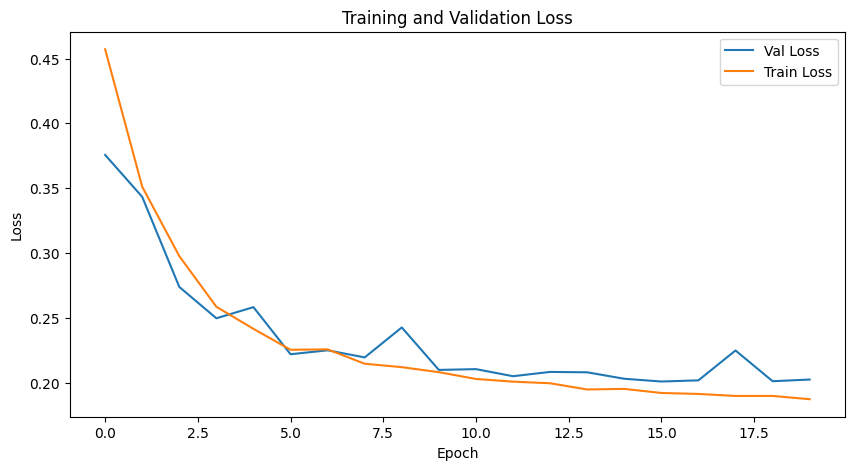

In [7]:
history = trainer.history[0]
plt.figure(figsize=(10, 5))
plt.plot(history["val_loss"], label="Val Loss")
plt.plot(history["train_loss"], label="Train Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


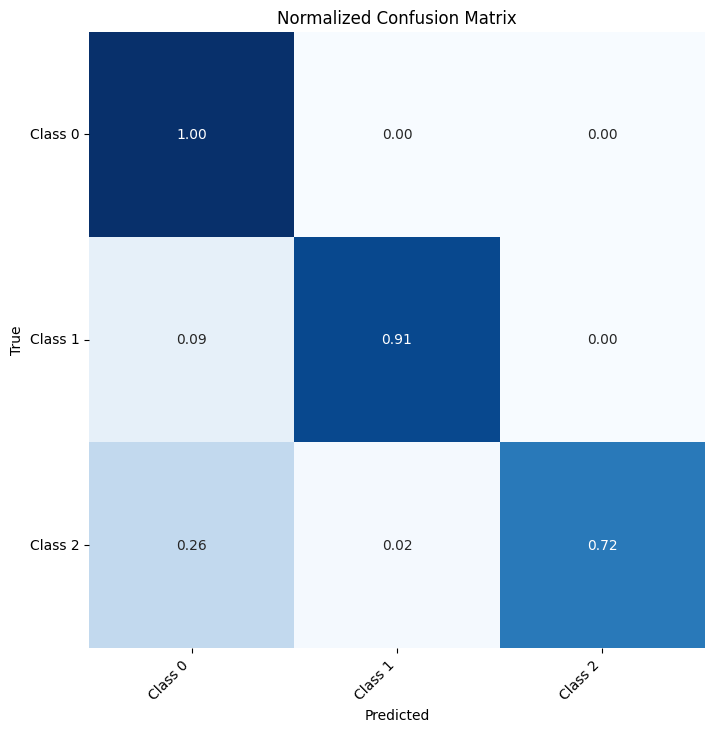

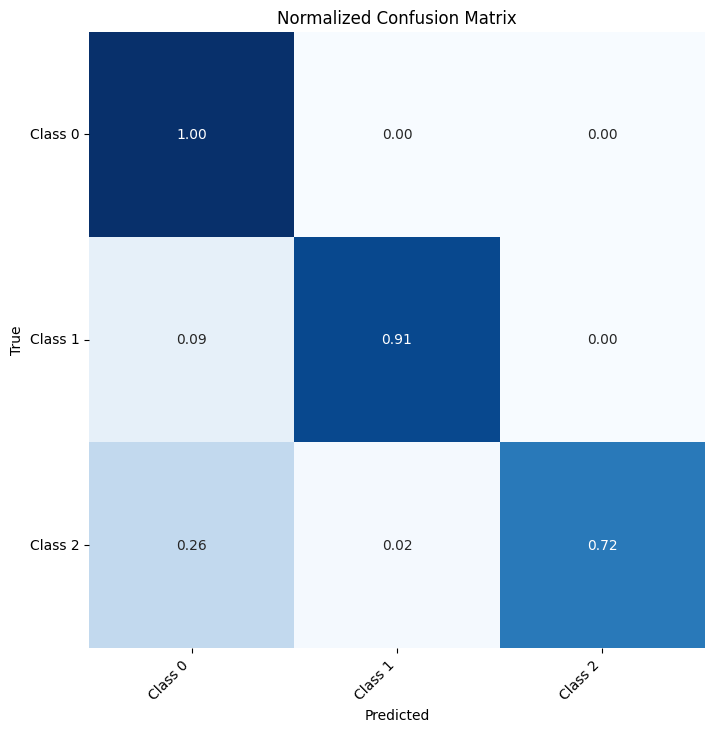

In [8]:
# Visualize training history
visualization_config = AssessmentVisualizationConfig(
    class_names=["Class 0", "Class 1", "Class 2"],
)
plotter = AssessmentVisualization(config=visualization_config)
plotter.plot_confusion_matrix(
    y_true=results["true_values"],
    y_pred=results["predictions"],
    normalize=True,
    title="Normalized Confusion Matrix",
)

__________

### Using Cross-Validation with 5 Folds

We can simply pass two extra arguments (*cross_validation* and *n_splits*) to the **TrainerConfig** and it will train a model with it. 

In [9]:
# Example: Setup TrainerConfig with Kfold for cross-validation
trainer_config_cv = TrainerConfig(
    optimizer="adam",
    criterion="cross_entropy",
    batch_size=32,
    epochs=20,
    seed=11,
    config_model=mlp_config,
    learning_rate=0.001,
    cross_validation=True,
    n_splits=5,
)

trainer_cv = ModelTrainer(trainer_config_cv)

In [10]:
# Train the MLP model using cross-validation (StratifiedKFold)
# This will run 5-fold cross-validation and store history for each fold in trainer_cv.history

trainer_cv.train(x_train=dfs_final.iloc[:, :-1], y_train=dfs_final["label"].astype(int))

[Pipeline] Training | train_loss: 0.1937, val_loss: 0.1953: 100%|██████████| 20/20 [01:08<00:00,  3.44s/epoch]
[Pipeline] Training | train_loss: 0.1900, val_loss: 0.1804: 100%|██████████| 20/20 [01:11<00:00,  3.56s/epoch]
[Pipeline] Training | train_loss: 0.1841, val_loss: 0.1934: 100%|██████████| 20/20 [01:11<00:00,  3.55s/epoch]
[Pipeline] Training | train_loss: 0.1960, val_loss: 0.1998: 100%|██████████| 20/20 [01:06<00:00,  3.35s/epoch]
[Pipeline] Training | train_loss: 0.1917, val_loss: 0.1930: 100%|██████████| 20/20 [00:58<00:00,  2.90s/epoch]
[Pipeline] Training Fold 5: 100%|██████████| 5/5 [05:38<00:00, 67.74s/fold]


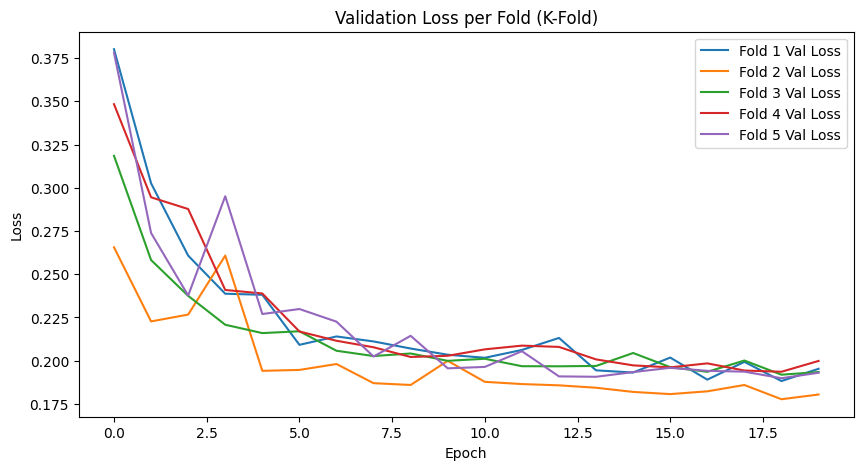

In [11]:
# Visualize K-Fold training history for all folds
plt.figure(figsize=(10, 5))
for i, fold_hist in enumerate(trainer_cv.history):
    if fold_hist is not None:
        plt.plot(fold_hist["val_loss"], label=f"Fold {i + 1} Val Loss")
plt.title("Validation Loss per Fold (K-Fold)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()